In [1]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Check GPU details
!nvidia-smi


Using device: cuda
Sun May  4 09:13:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              6W /   85W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

Epoch 1: 100%|██████████| 50/50 [00:01<00:00, 45.65it/s]


Epoch 1 - Train Acc: 0.5114, Val Acc: 0.5114


Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 119.61it/s]


Epoch 2 - Train Acc: 0.5682, Val Acc: 0.5568


Epoch 3: 100%|██████████| 50/50 [00:00<00:00, 113.06it/s]


Epoch 3 - Train Acc: 0.6168, Val Acc: 0.5852


Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 118.55it/s]


Epoch 4 - Train Acc: 0.6547, Val Acc: 0.6023


Epoch 5: 100%|██████████| 50/50 [00:00<00:00, 148.34it/s]


Epoch 5 - Train Acc: 0.6900, Val Acc: 0.6023


Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 87.00it/s]


Epoch 6 - Train Acc: 0.7216, Val Acc: 0.6875


Epoch 7: 100%|██████████| 50/50 [00:00<00:00, 125.82it/s]


Epoch 7 - Train Acc: 0.7778, Val Acc: 0.8011


Epoch 8: 100%|██████████| 50/50 [00:00<00:00, 149.23it/s]


Epoch 8 - Train Acc: 0.8213, Val Acc: 0.7670


Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 117.35it/s]


Epoch 9 - Train Acc: 0.8321, Val Acc: 0.8466


Epoch 10: 100%|██████████| 50/50 [00:00<00:00, 111.64it/s]


Epoch 10 - Train Acc: 0.8668, Val Acc: 0.8864


Epoch 11: 100%|██████████| 50/50 [00:00<00:00, 125.07it/s]


Epoch 11 - Train Acc: 0.8807, Val Acc: 0.8864


Epoch 12: 100%|██████████| 50/50 [00:00<00:00, 156.38it/s]


Epoch 12 - Train Acc: 0.8984, Val Acc: 0.8807


Epoch 13: 100%|██████████| 50/50 [00:00<00:00, 138.36it/s]


Epoch 13 - Train Acc: 0.9167, Val Acc: 0.9034


Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 129.32it/s]


Epoch 14 - Train Acc: 0.9287, Val Acc: 0.9034


Epoch 15: 100%|██████████| 50/50 [00:00<00:00, 150.15it/s]


Epoch 15 - Train Acc: 0.9495, Val Acc: 0.9091

Classification Report:
              precision    recall  f1-score   support

    MAN_MADE       0.84      0.91      0.87       221
     NATURAL       0.90      0.82      0.86       219

    accuracy                           0.87       440
   macro avg       0.87      0.87      0.87       440
weighted avg       0.87      0.87      0.87       440



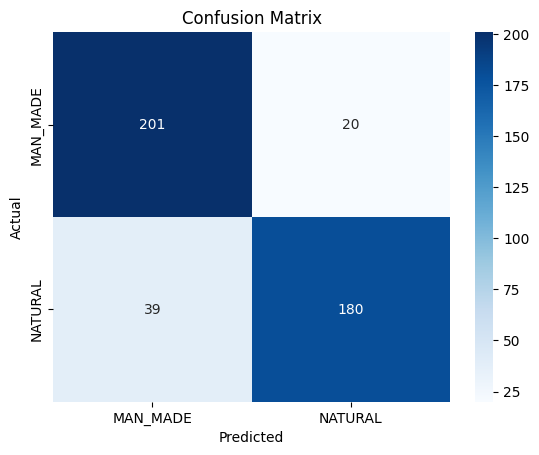

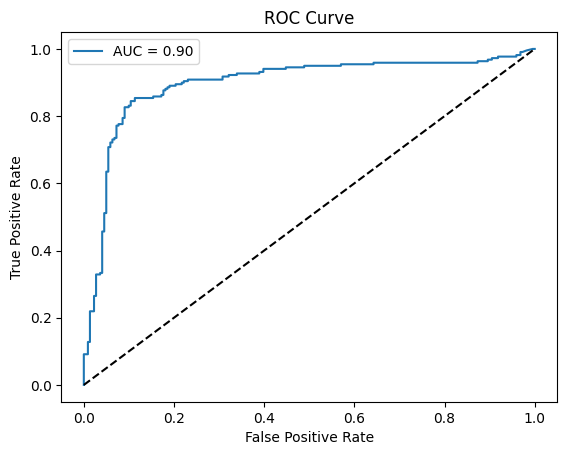

MAN_MADE


In [2]:
# 1. Import Libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import os

# 2. Load Data
df = pd.read_json("./data/processed/te/train.json", lines=True)

# 3. Extract Text and Binary Labels
X_texts = df["tokens"].apply(lambda x: " ".join(x)).tolist()
y_labels = df["labels"].apply(lambda x: list(x.keys())[0])

def label_to_binary(label):
    return "MAN_MADE" if "MAN_MADE_EVENT" in label else "NATURAL"

y_binary = [label_to_binary(label) for label in y_labels]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_binary)  # 0 = MAN_MADE, 1 = NATURAL

# 4. Build Custom Vocabulary
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for sentence in texts:
        tokens = sentence.strip().split()
        counter.update(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(X_texts)
vocab_size = len(vocab)

# 5. Encode Texts to Indices
def encode_texts(texts, vocab, max_len=100):
    encoded_inputs = []
    for text in texts:
        tokens = text.strip().split()
        ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens[:max_len]]
        padded = ids + [vocab["<PAD>"]] * (max_len - len(ids))
        encoded_inputs.append(padded)
    return torch.tensor(encoded_inputs)

X_encoded = encode_texts(X_texts, vocab, max_len=100)

# 6. Train-Validation-Test Split
X_temp, X_test, y_temp, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# 7. Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

train_loader = DataLoader(CustomDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(CustomDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(CustomDataset(X_test, y_test), batch_size=32)

# 8. BiLSTM Model with Custom Embeddings
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        pooled = lstm_out[:, -1, :]  # Take the last hidden state
        out = self.dropout(pooled)
        return self.fc(out).squeeze()

# 9. Setup Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=64).to(device)

counter = Counter(y_train)
neg, pos = counter[0], counter[1]
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# 10. Train Model
for epoch in range(15):
    model.train()
    train_correct = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)

    # Validation Accuracy
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
    val_acc = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# 11. Save Model
os.makedirs("./model", exist_ok=True)
torch.save(model.state_dict(), "./model/bilstm_binary_custom.pth")

# 12. Evaluation
model.eval()
all_logits, all_preds, all_labels = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        logits = model(inputs)
        probs = torch.sigmoid(logits).cpu()
        preds = (probs > 0.5).int()
        all_logits.extend(probs.numpy())
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_logits)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 13. Prediction Function (Custom Tokenizer)
def predict_event(text):
    model.eval()
    tokens = text.strip().split()
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens[:100]]
    padded = ids + [vocab["<PAD>"]] * (100 - len(ids))
    input_tensor = torch.tensor([padded]).to(device)
    with torch.no_grad():
        logit = model(input_tensor)
        prob = torch.sigmoid(logit).item()
    return "MAN_MADE" if prob < 0.5 else "NATURAL"

# Test
print(predict_event("భూకంపం సంభవించింది."))


In [3]:
# 14. Prediction Function
def predict_event(text):
    model.eval()
    tokens = text.strip().split()
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens[:100]]
    padded = ids + [vocab["<PAD>"]] * (100 - len(ids))
    input_tensor = torch.tensor([padded]).to(device)
    with torch.no_grad():
        logit = model(input_tensor)
        prob = torch.sigmoid(logit).item()
    return "MAN_MADE" if prob < 0.5 else "NATURAL"

# Test Predictions
print(predict_event("భూకంపం సంభవించింది."))
print(predict_event("ఫ్యాక్టరీలో పేలుడు జరిగింది."))

MAN_MADE
MAN_MADE


In [8]:
import pickle

binary_vocab = {
    "token2idx": vocab  # your vocab built using build_vocab()
}

with open("./model/binary_vocab.pkl", "wb") as f:
    pickle.dump(binary_vocab, f)


In [ ]:
import torch
import torch.nn as nn
import pickle
import gradio as gr
from typing import Dict

# --- Multi-Task Setup ---
multi_token2idx = pickle.load(open("./model/token2idx_multi.pkl", "rb"))
multi_label2idx = pickle.load(open("./model/label2idx_multi.pkl", "rb"))
multi_idx2label = {v: k for k, v in multi_label2idx.items()}

class MultiBiLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(MultiBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.norm = nn.LayerNorm(hidden_dim * 2)  # Adding LayerNorm
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = self.norm(lstm_out)  # Applying LayerNorm
        logits = self.fc(lstm_out)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_model = MultiBiLSTM(len(multi_token2idx), len(multi_label2idx)).to(device)
multi_model.load_state_dict(torch.load("./model/bilstm_multi.pt", map_location=device))
multi_model.eval()

def multi_predict(sentence: str) -> Dict[str, str]:
    words = sentence.strip().split()
    token_ids = [multi_token2idx.get(word, 0) for word in words]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    with torch.no_grad():
        output = multi_model(input_tensor)
        predictions = torch.argmax(output, dim=-1).cpu().numpy()[0]
    predicted_labels = [multi_idx2label[idx] for idx in predictions]
    return {word: label for word, label in zip(words, predicted_labels)}

def multi_styled_output(sentence):
    result = multi_predict(sentence)
    html = """
    <div style='display: flex; flex-wrap: wrap; gap: 12px; padding: 20px; 
                background: #ffffff; border-radius: 12px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);'>
    """
    color_palette = [
        "#48cd4a", "#cb4f78", "#e97e0b", "#48f061", "#8ff1df",
        "#9ead18", "#27e57b", "#e051c0", "#7add51", "#dab304", "#1dfafb"
    ]
    label_list = sorted(set(label for label in multi_idx2label.values() if label != "O"))
    label_colors = {label: color_palette[i % len(color_palette)] for i, label in enumerate(label_list)}
    label_colors["O"] = "#eef2f6"

    for word, tag in result.items():
        color = label_colors.get(tag, "#eef2f6")
        html += f"""
        <span style='padding: 8px 14px; border-radius: 10px; background: {color}; 
                    color: {'#fff' if tag != 'O' else '#2c3e50'}; font-family: 'Roboto', sans-serif; 
                    font-size: 15px; box-shadow: 0 2px 8px rgba(0,0,0,0.1); 
                    transition: transform 0.2s ease;'>
            {word} <sub style='font-size: 11px; margin-left: 5px; opacity: 0.9;'>{tag}</sub>
        </span>
        """
    html += "</div>"
    return html


# --- Binary Classifier Setup ---
binary_vocab = pickle.load(open("./model/binary_vocab.pkl", "rb"))
binary_token2idx = binary_vocab['token2idx']

class BinaryBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(BinaryBiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        output = self.dropout(lstm_out[:, -1, :])
        output = self.fc(output)
        return self.sigmoid(output)

binary_model = BinaryBiLSTMClassifier(len(binary_token2idx), embed_dim=128, hidden_dim=64, output_dim=1).to(device)
binary_model.load_state_dict(torch.load("./model/bilstm_binary_custom.pth", map_location=device))
binary_model.eval()

def binary_predict(sentence):
    tokens = sentence.strip().split()
    token_ids = [binary_token2idx.get(tok, 0) for tok in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    with torch.no_grad():
        output = binary_model(input_tensor).squeeze()
    return " MAN MADE" if output.item() < 0.5 else " NATURAL"

# --- Combined Gradio App ---
custom_css = """
/* Full-screen layout */
body, .gradio-container {
    background: linear-gradient(135deg, #74ebd5 0%, #acb6e5 100%);
    font-family: 'Roboto', sans-serif;
    color: #2c3e50;
    margin: 0;
    padding: 0;
    min-height: 100vh;
    display: flex;
    flex-direction: column;
    overflow-x: hidden;
}

/* Main container */
.container {
    max-width: 1500px;
    margin: 0 auto;
    padding: 30px;
    flex-grow: 1;
    background: rgba(255, 255, 255, 0.9);
    border-radius: 20px;
    box-shadow: 0 10px 30px rgba(0,0,0,0.1);
    margin-top: 20px;
    margin-bottom: 20px;
}

/* Title and description */
h1 {
    color: #2c3e50;
    text-align: center;
    font-size: 2.5em;
    margin-bottom: 10px;
    font-weight: 700;
    text-shadow: 0 2px 5px rgba(0,0,0,0.1);
    animation: fadeIn 1s ease;
}
.description {
    color: #636e72;
    text-align: center;
    font-size: 1.1em;
    margin-bottom: 20px;
    font-weight: 300;
}

/* Task buttons */
.task-btn {
    background: linear-gradient(to right, #6c5ce7, #a29bfe) !important;
    color: white !important;
    border-radius: 12px !important;
    padding: 10px 20px !important;
    font-size: 15px !important;
    font-weight: 500;
    border: none !important;
    box-shadow: 0 4px 15px rgba(108, 92, 231, 0.3);
    transition: transform 0.2s ease, box-shadow 0.2s ease;
    margin: 5px;
}
.task-btn:hover {
    transform: translateY(-2px);
    box-shadow: 0 6px 20px rgba(108, 92, 231, 0.4);
}
.task-btn.active {
    background: linear-gradient(to right, #e84393, #ff7675) !important;
}

/* Input area */
textarea {
    background: #fff !important;
    border: 2px solid #dfe6e9 !important;
    border-radius: 12px !important;
    padding: 15px !important;
    font-size: 15px !important;
    box-shadow: 0 4px 10px rgba(0,0,0,0.05);
    transition: border-color 0.3s ease, box-shadow 0.3s ease;
}
textarea:focus {
    border-color: #6c5ce7 !important;
    box-shadow: 0 4px 15px rgba(108, 92, 231, 0.2);
}

/* Submit buttons */
button.submit-btn {
    background: linear-gradient(to right, #6c5ce7, #a29bfe) !important;
    color: white !important;
    border-radius: 12px !important;
    padding: 12px 25px !important;
    font-size: 15px !important;
    font-weight: 500;
    border: none !important;
    box-shadow: 0 4px 15px rgba(108, 92, 231, 0.3);
    transition: transform 0.2s ease, box-shadow 0.2s ease;
}
button.submit-btn:hover {
    transform: translateY(-2px);
    box-shadow: 0 6px 20px rgba(108, 92, 231, 0.4);
}

/* Output area */
.output-html, .output-text {
    margin-top: 25px;
    animation: slideUp 0.5s ease;
}

/* Example boxes */
.example-box {
    background: #ffffff;
    border: 2px solid #dfe6e9;
    border-radius: 10px;
    padding: 10px 15px;
    margin: 5px;
    font-size: 13px;
    color: #2c3e50;
    cursor: pointer;
    box-shadow: 0 2px 5px rgba(0,0,0,0.05);
    transition: all 0.2s ease;
    display: inline-block;
}
.example-box:hover {
    border-color: #6c5ce7;
    transform: translateY(-2px);
    box-shadow: 0 4px 10px rgba(108, 92, 231, 0.2);
}

/* Tag hover effect */
span[style*='padding: 8px 14px'] {
    cursor: pointer;
}
span[style*='padding: 8px 14px']:hover {
    transform: scale(1.05);
}

/* Animations */
@keyframes fadeIn {
    from { opacity: 0; }
    to { opacity: 1; }
}
@keyframes slideUp {
    from { transform: translateY(20px); opacity: 0; }
    to { transform: translateY(0); opacity: 1; }
}
"""

# Interface
with gr.Blocks(css=custom_css) as demo:
    active_task = gr.State(value="multi")

    gr.Markdown("""
    # Telugu Event Detection
    <div class='description'>
        Switch between multi-task tagging and binary classification with ease!
    </div>
    """)

    with gr.Row():
        multi_btn = gr.Button("Multi-Task Tagging", elem_classes=["task-btn"])
        binary_btn = gr.Button("Binary Classification", elem_classes=["task-btn"])

    # Multi-task UI
    with gr.Group(visible=True) as multi_group:
        with gr.Row():
            with gr.Column(scale=1, min_width=700):
                multi_input = gr.Textbox(
                    label="Enter Your Telugu Sentence",
                    lines=2,
                    placeholder="తెలుగు వాక్యం ఇక్కడ టైప్ చేయండి... (Type here)",
                )
                multi_submit = gr.Button("Tag Now", elem_classes=["submit-btn"])
                with gr.Row():
                    gr.Markdown("**Try These:**")
                with gr.Row():
                    for example in ["""రైల్వే స్టేషన్ వద్ద భారీ ప్రమాదం జరిగింది. దాదాపు 20 మంది గాయపడ్డారు. 
అగ్నిమాపక సిబ్బంది వచ్చి మంటలను అదుపు చేశారు. పోలీసులు ఘటనాస్థలానికి చేరుకున్నారు.""",
        "పిడుగు పడడంతో చెట్టు విరిగిపడింది.",
        "బాంబు పేలుడు చోటుచేసుకుంది.",
        "రైలు పట్టాలు తప్పింది."]:
                        gr.Button(example, elem_classes=["example-box"]).click(
                            fn=lambda x=example: x,
                            outputs=multi_input
                        )
            with gr.Column(scale=1, min_width=700):
                multi_output = gr.HTML(label="Tagged Output")

    # Binary UI
    with gr.Group(visible=False) as binary_group:
        with gr.Row():
            with gr.Column(scale=1, min_width=700):
                binary_input = gr.Textbox(
                    label="Enter Telugu Event Description",
                    lines=2,
                    placeholder="తెలుగులో ఒక సంఘటనను ప్రవేశపెట్టండి... (Type here)",
                )
                binary_submit = gr.Button("Classify Now", elem_classes=["submit-btn"])
                with gr.Row():
                    gr.Markdown("**Try These:**")
                with gr.Row():
                    for example in ["భూకంపం సంభవించింది.", "బాంబు పేలుడు చోటుచేసుకుంది.","ఫ్యాక్టరీలో పేలుడు జరిగింది","రైలు పట్టాలు తప్పి రైలు ప్రమాదం జరిగింది."]:
                        gr.Button(example, elem_classes=["example-box"]).click(
                            fn=lambda x=example: x,
                            outputs=binary_input
                        )
            with gr.Column(scale=1, min_width=700):
                binary_output = gr.Textbox(label="Prediction")

    # Button click handlers
    def set_multi_task(task):
        return "multi", gr.update(visible=True), gr.update(visible=False)
    
    def set_binary_task(task):
        return "binary", gr.update(visible=False), gr.update(visible=True)

    multi_btn.click(
        fn=set_multi_task,
        inputs=active_task,
        outputs=[active_task, multi_group, binary_group]
    )
    binary_btn.click(
        fn=set_binary_task,
        inputs=active_task,
        outputs=[active_task, multi_group, binary_group]
    )

    # Submit handlers
    multi_submit.click(
        fn=multi_styled_output,
        inputs=multi_input,
        outputs=multi_output
    )
    binary_submit.click(
        fn=binary_predict,
        inputs=binary_input,
        outputs=binary_output
    )

demo.launch(share=True)


C:\Users\kotav\AppData\Local\Temp\ipykernel_13492\2563989612.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  multi_model.load_state_dict(torch.load("./model/bilstm_mult

Running on local URL:  http://127.0.0.1:7864

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
